<div style="background-color:#2b0000; color:white; padding:25px; border-radius:10px; 
            text-align:center; font-family:'Segoe UI', sans-serif;">

  <h1 style="margin-bottom:8px;"> Cars 4 You 🏎️💨</h1>
  <h3 style="margin-top:0; font-style:italic; font-weight:normal; color:#f05a5a;">
    Auxiliary Notebook – Preprocessing
  </h3>

  <hr style="width:60%; border:1px solid #700000; margin:15px auto;">

  <p style="margin:5px 0; font-size:15px;">
    <b>Group 4</b> - Machine Learning Project (2025/2026)
  </p>
  <p style="margin:0; font-size:13px; color:#e3bdbd;">
    Master in Data Science and Advanced Analytics - Nova Information Management School
  </p>
</div>

<br>

<div style="background-color:#3a0808; color:#f4eaea; padding:15px 20px; border-left:5px solid #700000; 
            border-radius:6px; font-family:'Segoe UI', sans-serif; font-size:14px;">

  <b>Notebook Context</b><br>
  In this auxiliar notebook, we will perform the preprocessing on train, validation using cross-validation to do model assessment and later do preprocessing on the whole train and test datasets to train our final model. 
  
  We will start by dividing the original train dataset in 5 folds, each one with a train set and a validation set. We will perform preprocessing on each fold and then we will apply that preprocessing on the original train fold. 
</div>

<br>

<div style="text-align:center; margin-top:10px;">
  <a href="../main.ipynb" 
     style="display:inline-block; background-color:#700000; color:#fff; 
            padding:8px 16px; text-decoration:none; border-radius:6px; 
            font-family:'Segoe UI', sans-serif; font-size:13px;">
     <- Back to Main Notebook
  </a>
</div>

<br>

<div style="text-align:right; font-size:12px; color:#d8bfbf;">
  Last updated: December 2025
</div>


In [14]:
# Core libraries
import numpy as np
import pandas as pd
from pathlib import Path
import os
import seaborn as sns
import matplotlib.pyplot as plt
import pickle

from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.impute import KNNImputer

from sklearn.model_selection import KFold

## 1. Creating Folds for Cross-Validation

Here we create a cross-validation pipeline to handle the training dataset, 
ensuring all transformations happen inside each fold to prevent data leakage.

So the pipeline inside the CV will follow this pseudocode:

```py
for each fold:
    validation, train = split(training data)
    preprocess train data
    apply that preprocessing to both train and validation

    train model on preprocessed train data

    evaluate model on preprocessed validation data

    store: model and validation predictions

choose best model on CV to train on full trainset and get predictions on test set 
```

We will import the original train dataset:

In [15]:
train_df = pd.read_csv('../data/train.csv') 

Before creating the folds, in a way of keeping things simple, the rows where both brand and model are NaN are going to be dropped here, before any splitting.

In [16]:
# Drop rows where BOTH Brand AND model are missing
print("="*80)
print("DATA CLEANING: Dropping rows with BOTH Brand AND model missing")
print("="*80)

initial_size = len(train_df)
both_missing = train_df['Brand'].isna() & train_df['model'].isna()
rows_to_drop = both_missing.sum()

print(f"Initial dataset: {initial_size} rows")
print(f"Rows with BOTH Brand AND model missing: {rows_to_drop}")

# Drop those rows
train_df = train_df[~both_missing].copy()

print(f"Dataset after drop: {len(train_df)} rows")
print(f"Total dropped: {rows_to_drop} rows ({rows_to_drop/initial_size*100:.2f}%)")
print("="*80)

DATA CLEANING: Dropping rows with BOTH Brand AND model missing
Initial dataset: 75973 rows
Rows with BOTH Brand AND model missing: 36
Dataset after drop: 75937 rows
Total dropped: 36 rows (0.05%)


### 1.1. Create CV Folds

Since preprocessing takes quite some time, but is deterministic, we can split in folds, preprocess and save as csvs, and instead of re-running everything, just import the csvs from the folder.

In this step, we will create the folds, and save them:

In [17]:
results_dir = '../results/preprocessing_results/folds'
Path(results_dir).mkdir(parents=True, exist_ok=True)

In [18]:
def create_and_save_cv_folds():   
    
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    
    for fold_idx, (train_idx, val_idx) in enumerate(kf.split(train_df), 1):
        train_fold = train_df.iloc[train_idx].reset_index(drop=True)
        val_fold = train_df.iloc[val_idx].reset_index(drop=True)
        
        # Create fold directory
        fold_dir = os.path.join(results_dir, f'fold_{fold_idx}')
        Path(fold_dir).mkdir(parents=True, exist_ok=True)
        
        # Save folds
        train_path = os.path.join(fold_dir, f'train{fold_idx}.csv')
        val_path = os.path.join(fold_dir, f'validation{fold_idx}.csv')
        
        train_fold.to_csv(train_path, index=False)
        val_fold.to_csv(val_path, index=False)
        
        print(f"Fold {fold_idx}: train={len(train_fold)}, validation={len(val_fold)}")
    
    print(f"\nAll folds saved to: {results_dir}")

In [19]:
# Create and save folds
create_and_save_cv_folds()

Fold 1: train=60749, validation=15188
Fold 2: train=60749, validation=15188
Fold 3: train=60750, validation=15187
Fold 4: train=60750, validation=15187
Fold 5: train=60750, validation=15187

All folds saved to: ../results/preprocessing_results/folds


## 2. Preprocessing Steps Utils
Here are presented the functions used in the first preprocessing steps to fill missing values, handle outliers, and correct data types


### 2.1 Fixing the Categorical Input

In the aforementioned `Nominal_Variables_Fixing.ipynb` notebook, we created a process to handle the multiple misspelled variations of the same category that appear in our data. 
Here, we will apply the results to fix the categorical inputs.

In [20]:
brand_mapping = pd.read_csv('../results/mapping_dicts/brand_mapping.csv')
fuelType_mapping = pd.read_csv('../results/mapping_dicts/fuelType_mapping.csv')
model_mapping = pd.read_csv('../results/mapping_dicts/model_mapping.csv')
transmission_mapping = pd.read_csv('../results/mapping_dicts/transmission_mapping.csv')

brand_map = dict(zip(brand_mapping["Variation"].str.strip(), brand_mapping["AssignedValue"].str.strip()))
fuelType_map = dict(zip(fuelType_mapping["Variation"].str.strip(), fuelType_mapping["AssignedValue"].str.strip()))
model_map = dict(zip(model_mapping["Variation"].str.strip(), model_mapping["AssignedValue"].str.strip()))
transmission_map = dict(zip(transmission_mapping["Variation"].str.strip(), transmission_mapping["AssignedValue"].str.strip()))

In [21]:
def fix_categorical_input(car_dict):
    for key in ["Brand", "model", "fuelType", "transmission"]:
        value = car_dict.get(key)
        if pd.isna(value):
            car_dict[key] = np.nan  
        else:
            car_dict[key] = str(value).strip() 

    if not pd.isna(car_dict.get("Brand")):
        car_dict["Brand"] = brand_map.get(car_dict["Brand"], car_dict["Brand"])
    
    if not pd.isna(car_dict.get("fuelType")):
        car_dict["fuelType"] = fuelType_map.get(car_dict["fuelType"], car_dict["fuelType"])
    
    if not pd.isna(car_dict.get("model")):
        car_dict["model"] = model_map.get(car_dict["model"], car_dict["model"])
    
    if not pd.isna(car_dict.get("transmission")):
        car_dict["transmission"] = transmission_map.get(car_dict["transmission"], car_dict["transmission"])
    
    return car_dict

### 2.2 Fixing Missing Values in Categorical Features
In other to fix missing values in categorical features, we will act in this way:

We first check if we have both `Brand` and `model` missing. 

1. If we do, we will filter our dataset by the given `engineSize` and fill with the mode `Brand` with that `engineSize`. The same occurs for `model`. 

2. If we can not fill both values with `engineSize`, we will try to do it applying the same process with `transmission`.

3. If we still can not, we will do it with `fuelType`. In the training set, this was enough to fill all missing pairs of `Brand` and `model`

**This problem does not exist on train dataset because we dropped these lines. Can be applicable to the test set.**

In [22]:
def guess_brand_model(car_dict, df):    
    """
    Guess when both Brand and model are missing
    """
    if pd.notna(car_dict.get("Brand")) or pd.notna(car_dict.get("model")):
        return car_dict
    
    engine = car_dict.get("engineSize")
    trans = car_dict.get("transmission")
    fuel = car_dict.get("fuelType")
    
    result_brand = np.nan
    result_model = np.nan
    
    # 1st priority: engineSize
    if pd.notna(engine):
        matches = df[df["engineSize"] == engine]
        if len(matches) > 0:
            if pd.isna(car_dict.get("Brand")):
                brand_mode = matches["Brand"].mode()
                if len(brand_mode) > 0:
                    result_brand = brand_mode[0]
            
            if pd.isna(car_dict.get("model")):
                model_mode = matches["model"].mode()
                if len(model_mode) > 0:
                    result_model = model_mode[0]
    
    # 2nd priority: transmission (if still missing)
    if (pd.isna(result_brand) or pd.isna(result_model)) and pd.notna(trans):
        matches = df[df["transmission"] == trans]
        if len(matches) > 0:
            if pd.isna(result_brand) and pd.isna(car_dict.get("Brand")):
                brand_mode = matches["Brand"].mode()
                if len(brand_mode) > 0:
                    result_brand = brand_mode[0]
            
            if pd.isna(result_model) and pd.isna(car_dict.get("model")):
                model_mode = matches["model"].mode()
                if len(model_mode) > 0:
                    result_model = model_mode[0]
    
    # 3rd priority: fuelType (if still missing)
    if (pd.isna(result_brand) or pd.isna(result_model)) and pd.notna(fuel):
        matches = df[df["fuelType"] == fuel]
        if len(matches) > 0:
            if pd.isna(result_brand) and pd.isna(car_dict.get("Brand")):
                brand_mode = matches["Brand"].mode()
                if len(brand_mode) > 0:
                    result_brand = brand_mode[0]
            
            if pd.isna(result_model) and pd.isna(car_dict.get("model")):
                model_mode = matches["model"].mode()
                if len(model_mode) > 0:
                    result_model = model_mode[0]
    
    # Update the dictionary with found values
    if pd.notna(result_brand):
        car_dict["Brand"] = result_brand
    if pd.notna(result_model):
        car_dict["model"] = result_model
    
    return car_dict

If we just have the `model` missing, but we have the `Brand`, we will act on these priorities:

1. mode model with the given `Brand` and `engineSize`. This was the first in the priority list due to the fact that it is able to narrow the model down more. There is more likelihood of choosing an close/alike model, from the same brand, if they have the same engine size. The same cannot be stated regarding the other features.
   
2. mode model with the given `Brand` and `transmission`
3. mode model with the given `Brand` and `fuelType`
4. mode model with the given `Brand` only

In [23]:
def get_model(brand_name, engineSize, transmission, fuelType, df):
    # Filter only cars from the same brand
    same_brand = df[df["Brand"] == brand_name]
    
    if len(same_brand) == 0:
        return np.nan
    
    # 1st priority: brand + engineSize
    if pd.notna(engineSize):
        mode = same_brand[same_brand["engineSize"] == engineSize]["model"].mode()
        if len(mode) > 0:
            return mode[0]
    
    # 2nd priority: brand + transmission
    if pd.notna(transmission):
        mode = same_brand[same_brand["transmission"] == transmission]["model"].mode()
        if len(mode) > 0:
            return mode[0]
    
    # 3rd priority: brand + fuelType
    if pd.notna(fuelType):
        mode = same_brand[same_brand["fuelType"] == fuelType]["model"].mode()
        if len(mode) > 0:
            return mode[0]
    
    # 4th priority: brand only
    mode = same_brand["model"].mode()
    if len(mode) > 0:
        return mode[0]
    
    return np.nan

In the case we have `model`, but do not have `Brand`, we just need the previous mappings to map the `model` to the corresponding `Brand`

In [24]:
def get_brand_from_model(model_name):
    """
    Given a model name, return its corresponding Brand.
    """
    map_dict = dict(zip(
        model_mapping["AssignedValue"].str.strip(),
        model_mapping["Brand"].str.strip()
    ))
    model_name = str(model_name).strip()
    return map_dict.get(model_name, np.nan)

Here, we put together everything we explained before and act on missing `fuelType` and `transmission`.

For `fuelType` and `transmission`, we will fill the missing value with the mode of it's `model` and if it is not possible, the mode of the entire dataset.

In [25]:
def fix_empty_categorical(car_dict, df):
    """
    Fill missing categorical values using mode of the model.
    If model is missing, it returns np.nan (to signal row should be dropped).
    """
    if car_dict["fuelType"] == "Other":
        car_dict["fuelType"] = np.nan
    if car_dict["transmission"] == "Unknown":
        car_dict["transmission"] = np.nan

    car_dict = guess_brand_model(car_dict, df) # only changes if both brand and model are missing
        
    # Fix model if missing
    if pd.isna(car_dict["model"]):
        car_dict["model"] = get_model(car_dict["Brand"], car_dict["engineSize"],
                                      car_dict["transmission"], car_dict["fuelType"], df)

    # Fix Brand if missing
    if pd.isna(car_dict["Brand"]):
        car_dict["Brand"] = get_brand_from_model(car_dict["model"])
    
    # Fix fuelType if missing
    if pd.isna(car_dict["fuelType"]):
        if not pd.isna(car_dict["model"]):
            model_clean = str(car_dict["model"]).strip()
            mode_fuelType = df.loc[df["model"].str.strip().str.lower() == model_clean.lower(), "fuelType"].mode()
            car_dict["fuelType"] = mode_fuelType[0] if len(mode_fuelType) > 0 else df["fuelType"].mode()[0]
        else:
            car_dict["fuelType"] = df["fuelType"].mode()[0]
    
    # Fix transmission if missing
    if pd.isna(car_dict["transmission"]):
        if not pd.isna(car_dict["model"]):
            model_clean = str(car_dict["model"]).strip()
            mode_transmission = df.loc[df["model"].str.strip().str.lower() == model_clean.lower(), "transmission"].mode()
            car_dict["transmission"] = mode_transmission[0] if len(mode_transmission) > 0 else df["transmission"].mode()[0]
        else:
            car_dict["transmission"] = df["transmission"].mode()[0]
    
    return car_dict

### 2.3 Fixing Missing Values in Numerical Features
Computes the median of a numerical feature using progressively less restrictive filters:
first applying the main grouping columns available in `car_dict`, then a fallback grouping; and
finally the global median if no valid subgroup median can be calculated.

In [26]:
def get_median_with_fallback(df, car_dict, feature, groupby_cols, fallback_groupby):

    mask = pd.Series([True] * len(df), index=df.index)
    for col in groupby_cols:
        value = car_dict.get(col)
        if not pd.isna(value):
            mask = mask & (df[col] == value)

    filtered_data = df.loc[mask, feature]
    if len(filtered_data) > 0 and not filtered_data.isna().all():
        median_val = filtered_data.median()
        if not pd.isna(median_val):
            return median_val

    if fallback_groupby:
        mask = pd.Series([True] * len(df), index=df.index)
        for col in fallback_groupby:
            value = car_dict.get(col)
            if not pd.isna(value):
                mask = mask & (df[col] == value)

        filtered_data = df.loc[mask, feature]
        if len(filtered_data) > 0 and not filtered_data.isna().all():
            median_val = filtered_data.median()
            if not pd.isna(median_val):
                return median_val

    return df[feature].median()


Using the function above, we will fill missing:

- `Year` – based on the median `year` of the cars with that `model`

- `Mileage` – based on the median `mileage` of the cars with that `model` and that `year`. We will use just `year` as a fallback

- `EngineSize` – based on the median `engineSize` of the cars with that `model` and that `fuelType`. We will use just `model` as a fallback

- `Tax` – based on the median `tax` of the cars with that `model` and that `year`. We will use just `year` as a fallback

- `MPG` – based on the median `mpg` of the cars with that `model` and that `fuelType`. We will use just `fuelType` as a fallback

- `PreviousOwners` – based on the median `previousOwners` of the cars with that `model` and that `year`. We will use just `model` as a fallback

In [27]:
def fix_empty_numerical(car_dict, df):
    """
    Fill missing numerical values using medians based on similar cars.
    """
    # Year - Median within the same model (no explicit fallback; global median used if needed)
    if pd.isna(car_dict["year"]):
        car_dict["year"] = get_median_with_fallback(
            df,
            car_dict,
            feature='year',
            groupby_cols=['model'],
            fallback_groupby=None
    )
        

    # Mileage - Median within (model, year), fallback to year only, otherwise global median
    if pd.isna(car_dict["mileage"]):
        car_dict["mileage"] = get_median_with_fallback(
            df,
            car_dict,
            feature='mileage',
            groupby_cols=['model', 'year'],
            fallback_groupby=['year']
        )

    # Engine Size - Median within (model, fuelType), fallback to model only, otherwise global median
    if pd.isna(car_dict["engineSize"]):
        car_dict["engineSize"] = get_median_with_fallback(
            df,
            car_dict,
            feature='engineSize',
            groupby_cols=['model', 'fuelType'],
            fallback_groupby=['model']
        )

    # Tax - Median within (model, year), fallback to year only, otherwise global median
    if pd.isna(car_dict["tax"]):
        car_dict["tax"] = get_median_with_fallback(
            df,
            car_dict,
            feature='tax',
            groupby_cols=['model', 'year'],
            fallback_groupby=['year']
        )

    # MPG - Median within (model, fuelType), fallback to fuelType only, otherwise global median
    if pd.isna(car_dict["mpg"]):
        car_dict["mpg"] = get_median_with_fallback(
            df,
            car_dict,
            feature='mpg',
            groupby_cols=['model', 'fuelType'],
            fallback_groupby=['fuelType']
        )  
    # PreviousOwners - Median within (model, year), fallback to model only, otherwise global median
    if pd.isna(car_dict["previousOwners"]):
        car_dict["previousOwners"] = get_median_with_fallback(
            df,
            car_dict,
            feature='previousOwners',
            groupby_cols=['model', 'year'],
            fallback_groupby=['model']
        )  

    return car_dict

### 2.4 Handling Outliers
We will apply various outlier handling techniques. We will use plateaus, manual removals and Local Outlier Factor (LOF)

#### 2.4.1 Handling Outliers Using Plateaus

This function identifies the **plateau point** where a feature's impact on price stabilizes.

The process is as follows:
1. **Bin the data** 
2. **Calculate median price** per bin
3. **Smooth the curve** using a rolling window (median with neighboors) to reduce noise
4. **Find the plateau** by detecting where the gradient (slope) approaches zero

In [28]:
def get_median_curve(df, feature, bin_size=np.nan, smooth_window=5):
    """
    Compute smoothed median price per feature bin and extract the plateau point.
    """
    data = df[[feature, 'price']].dropna().copy()

    if feature == 'mileage':
        data = data[data['mileage'] > 0].copy()

    if pd.notna(bin_size):
        bin_col = f'{feature}_bin'
        data[bin_col] = (data[feature] // bin_size) * bin_size
        group_col = bin_col
    else:
        group_col = feature

    median_df = (
        data
        .groupby(group_col)['price']
        .median()
        .reset_index()
        .sort_values(group_col)
    )

    window = min(smooth_window, len(median_df))
    
    if window < 2:
        median_df['price_smooth'] = median_df['price']
    else:
        median_df['price_smooth'] = (
            median_df['price']
            .rolling(window=window, center=True)
            .mean()
        )

    valid = median_df['price_smooth'].notna()

    if valid.sum() < 2:
        y = median_df['price'].values
        x = median_df[group_col].values
        grad = np.gradient(y)
        turn_pos = np.argmin(np.abs(grad))
        turn_value = x[turn_pos]
        return turn_value

    y_smooth = median_df.loc[valid, 'price_smooth'].values
    x_vals   = median_df.loc[valid, group_col].values
    grad = np.gradient(y_smooth)
    turn_pos = np.argmin(np.abs(grad))
    turn_value = x_vals[turn_pos]

    return turn_value

This effect is particularly observed with `year` and `mileage` and so, it will be where we will observe it.

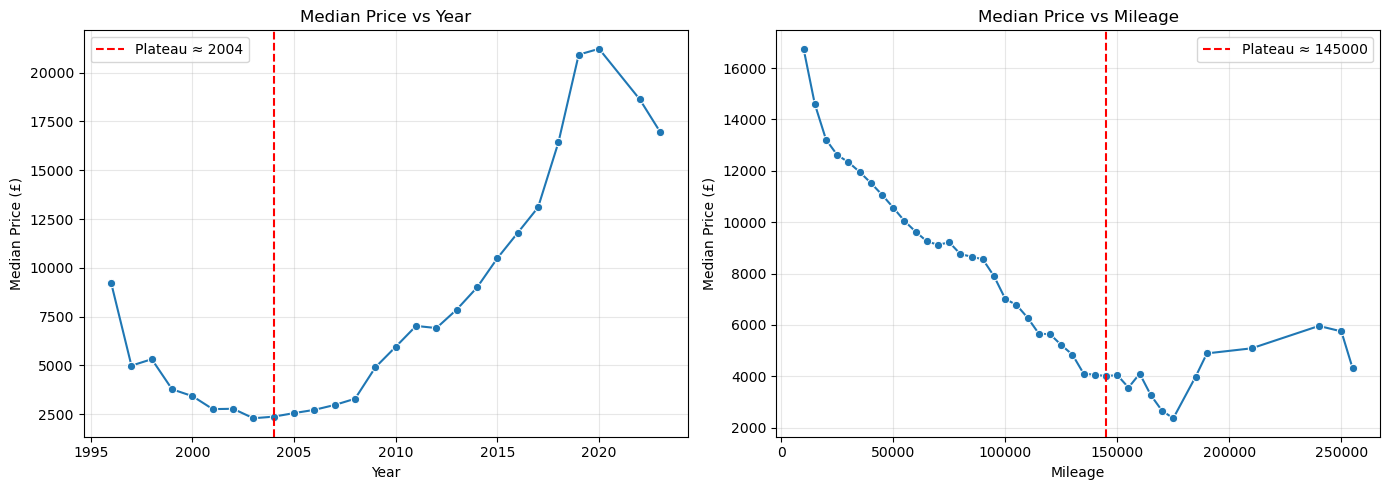

In [29]:
features_config = {
    'year':    {'bin_size': 1,     'smooth_window': 3},
    'mileage': {'bin_size': 5_000, 'smooth_window': 5},
}

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for i, (feature, params) in enumerate(features_config.items()):
    # Get data
    data = train_df[[feature, 'price']].dropna().copy()
    if feature == 'mileage':
        data = data[data['mileage'] > 0].copy()
    
    # Bin and compute median
    bin_col = f'{feature}_bin'
    data[bin_col] = (data[feature] // params['bin_size']) * params['bin_size']
    median_df = data.groupby(bin_col)['price'].median().reset_index().sort_values(bin_col)
    
    # Smooth
    window = min(params['smooth_window'], len(median_df))
    median_df['price_smooth'] = median_df['price'].rolling(window=window, center=True).mean() if window >= 2 else median_df['price']
    
    # Get plateau
    plateau_value = get_median_curve(train_df, feature, bin_size=params['bin_size'], smooth_window=params['smooth_window'])
    
    # Plot
    ax = axes[i]
    sns.lineplot(data=median_df, x=bin_col, y='price_smooth', marker='o', ax=ax)
    ax.axvline(plateau_value, color='red', linestyle='--', label=f'Plateau ≈ {plateau_value:.0f}')
    ax.set_title(f"Median Price vs {feature.capitalize()}")
    ax.set_xlabel(feature.capitalize())
    ax.set_ylabel("Median Price (£)")
    ax.legend()
    ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

In [30]:
def compute_plateaus(df):
    """
    Compute plateau values for year and mileage.
    """
    features_config = {
        'year':    {'bin_size': 1,     'smooth_window': 3},
        'mileage': {'bin_size': 5_000, 'smooth_window': 5},
    }
    
    plateaus = {}
    for feature, params in features_config.items():
        plateau_value = get_median_curve(
            df,
            feature,
            bin_size=params['bin_size'],
            smooth_window=params['smooth_window'],
        )
        plateaus[feature] = plateau_value
    
    return plateaus

#### 2.4.2 Handling Outliers Manually

This step removes infeasible values and limits extreme observations using domain rules and plateau-based capping.

##### Plateau-based capping

For `year` and `mileage`, a plateau point is estimated from the smoothed median price curve. Beyond this point, price variation becomes irrelevant. Note: Each fold computes a different plateau for each feature, although should not vary much.

- `year` values below the plateau are capped to the plateau year.
- `mileage` values above the plateau are capped to the plateau mileage.

##### Removal vs replacement

- **Removed negatives**: `mileage`, `engineSize`, `previousOwners`  
  These variables were removed when negative because their values cannot be reliably inferred from other features. For example, a vehicle’s mileage cannot be assumed from characteristics such as engine size or tax, as cars with similar specifications may have been driven very different distances. The same reasoning applies to `engineSize` and `previousOwners`: their values are intrinsic properties that are not sufficiently determined by the remaining variables, making imputation arbitrary and likely to introduce noise.

- **Replaced and imputed**: `tax`, `mpg`  
  Negative values in these variables were treated as data-entry errors and replaced with `NaN`. Unlike the removed variables, `tax` and `mpg` show strong and structured relationships with other features (`engineSize`, `year`, and with each other), allowing KNN imputation to infer plausible values from similar vehicles without introducing unrealistic assumptions.


##### Manual rules applied

| Variable | Action | Justification |
|-----------|---------|---------------|
| **year** | Removed values above 2020 and capped values below the plateau year | Years beyond 2020 fall outside the temporal scope of the dataset. For older vehicles, the smoothed median price curve becomes approximately flat below the plateau year, indicating that additional ageing no longer leads to systematic price differences. Capping prevents very old cars from exerting undue influence while preserving observations. |
| **mileage** | Removed negative values and capped values above the plateau mileage | Negative mileage is physically impossible. The median price curve shows that depreciation stabilises beyond the plateau mileage, meaning further increases do not correspond to consistent price changes. Capping limits the impact of extreme usage without discarding valid records. |
| **tax** | Replaced negative values with NaN and imputed using KNN (k=5) with `engineSize`, `mpg`, `year` | Negative tax values are invalid but are likely caused by data-entry or encoding errors. Because tax is strongly related to vehicle characteristics, KNN imputation using correlated features provides plausible estimates while avoiding unnecessary row removal. |
| **mpg** | Removed values above 400 and replaced negative values with NaN, then imputed using KNN (k=5) with `tax`, `engineSize` | Extremely high or negative mpg values are implausible. However, affected records often remain informative in other variables, so KNN imputation reconstructs consistent values based on similar vehicles rather than discarding the observations. |
| **engineSize** | Removed negative values | Engine displacement is a physical quantity and negative values cannot occur in reality; such records are therefore non-recoverable. |
| **paintQuality%** | Clipped values to the \[0, 100\] range | This variable represents a bounded percentage. Values outside the valid range indicate measurement or data-entry errors and are corrected by clipping to the nearest admissible limit. |
| **previousOwners** | Removed negative values | The number of previous owners is a count variable. Negative values have no valid interpretation and cannot be reliably inferred. |


##### Why `StandardScaler`

`StandardScaler` is used because KNN and LOF rely on distance calculations. It is less sensitive to extreme values and preserves relative distances, unlike `MinMaxScaler`, which is dominated by min–max extremes.


In [31]:
def remove_manual_outliers(df, plateaus):
    """
    Remove outliers based on manual rules and plateau analysis.
    Returns cleaned df and removal statistics.
    """
    initial_rows = len(df)
    removal_stats = {
        'initial_rows': initial_rows,
        'year_above_2020': 0,
        'mileage_negative': 0,
        'mpg_above_400': 0,
        'engineSize_negative': 0,
        'previousOwners_negative': 0,
    }
    
    df = df.copy()
    
    # YEAR: Remove > 2020, cap lower bound at plateau
    removal_stats['year_above_2020'] = (df['year'] > 2020).sum()
    df = df[df['year'] <= 2020].copy()
    
    year_plateau = plateaus['year']
    df.loc[df['year'] < year_plateau, 'year'] = year_plateau
    
    # MILEAGE: Remove negatives, cap upper bound at plateau
    removal_stats['mileage_negative'] = (df['mileage'] < 0).sum()
    df = df[df['mileage'] >= 0].copy()
    
    mileage_plateau = plateaus['mileage']
    df.loc[df['mileage'] > mileage_plateau, 'mileage'] = mileage_plateau
    
    # TAX: Negatives → NaN → KNN imputation
    df.loc[df['tax'] < 0, 'tax'] = np.nan
    
    if df['tax'].isna().any():
        neigh_cols = ['engineSize', 'mpg', 'year']
        scaler = StandardScaler()
        neigh_scaled = scaler.fit_transform(df[neigh_cols])
        M = np.column_stack([df['tax'].to_numpy(), neigh_scaled])
        imputer = KNNImputer(n_neighbors=5, weights='distance')
        M_imp = imputer.fit_transform(M)
        df['tax'] = M_imp[:, 0]
    
    # MPG: Remove > 400, negatives → NaN → KNN imputation
    removal_stats['mpg_above_400'] = (df['mpg'] > 400).sum()
    df = df[df['mpg'] <= 400].copy()
    
    df.loc[df['mpg'] < 0, 'mpg'] = np.nan
    
    if df['mpg'].isna().any():
        neigh_cols = ['tax', 'engineSize']
        scaler = StandardScaler()
        neigh_scaled = scaler.fit_transform(df[neigh_cols])
        M = np.column_stack([df['mpg'].to_numpy(), neigh_scaled])
        imputer = KNNImputer(n_neighbors=5, weights='distance')
        M_imp = imputer.fit_transform(M)
        df['mpg'] = M_imp[:, 0]
    
    # ENGINE SIZE: Remove negatives
    removal_stats['engineSize_negative'] = (df['engineSize'] < 0).sum()
    df = df[df['engineSize'] >= 0].copy()
    
    # PREVIOUS OWNERS: Remove negatives
    removal_stats['previousOwners_negative'] = (df['previousOwners'] < 0).sum()
    df = df[df['previousOwners'] >= 0].copy()
    
    removal_stats['final_rows'] = len(df)
    removal_stats['total_removed'] = initial_rows - len(df)
    removal_stats['removal_rate'] = removal_stats['total_removed'] / initial_rows
    
    return df, removal_stats

#### 2.4.3 Handling Outliers Using Local Outlier Factor (LOF)

Local Outlier Factor (LOF) is a density-based algorithm that detects outliers by comparing each point's local density with its neighbors' density.

It starts by finding the K nearest neighbors for each point,

Then, calculates the local density
   - Measures how close neighbors are to each point
   - Dense regions are where neighbors are close
   - Sparse regions are where neighbors are far

And finally, computes LOF scores:
   
   $$\text{LOF}(p) = \frac{\text{Average density of neighbors}}{\text{Density of point } p}$$
   
   - **LOF ≈ 1**: Normal point (similar density to neighbors)
   - **LOF > 1**: Outlier (less dense than neighbors)
   - **LOF >> 1**: Strong outlier

In [32]:
def detect_lof_outliers(df):
    """
    Detect outliers using LOF on cleaned data.
    Returns outlier indices and statistics.
    """
    num_cols = ['year', 'mileage', 'tax', 'mpg', 'engineSize']
    X = df[num_cols]

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    lof = LocalOutlierFactor(
        n_neighbors=50,
        contamination=0.005
    )
    y_pred = lof.fit_predict(X_scaled)
    lof_scores = lof.negative_outlier_factor_


    outlier_mask = (y_pred == -1)
    outlier_indices = df.index[outlier_mask].tolist()

    lof_stats = {
        'total_outliers': len(outlier_indices),
        'outlier_rate': len(outlier_indices) / len(df),
        'min_lof_score': lof_scores.min(),
        'mean_lof_score': lof_scores.mean(),
    }

    return outlier_indices, lof_stats

### 2.5 Correcting Data Types
Here we will correct the datatypes of all features stating that 
- The features `year`and `previousOwners` must be integer values
- The features `mileage`, `tax`, `mpg`, `engineSize`,`paintQuality%` must be floats
- The features `Brand`, `model`, `transmission`, `fuelType`, must be strings

In [33]:
def correct_types(car_dict):
    """
    Convert features to correct data types.
    Maintains NaN for missing values.
    """
    # Ints
    int_features = ['year', 'previousOwners']
    for feature in int_features:
        if pd.notna(car_dict[feature]):
            car_dict[feature] = int(car_dict[feature])
    
    # Floats
    float_features = ['mileage', 'tax', 'mpg', 'engineSize', 'paintQuality%']
    for feature in float_features:
        if pd.notna(car_dict[feature]):
            car_dict[feature] = float(car_dict[feature])
    
    # Strings 
    str_features = ['Brand', 'model', 'transmission', 'fuelType']
    for feature in str_features:
        value = car_dict.get(feature)
    
        if pd.isna(value) or str(value).strip() == '':
            car_dict[feature] = np.nan
        else:
            car_dict[feature] = str(value).strip()
    
    return car_dict

### 2.6 Features to Scale


In [34]:
features_to_scale = ["model_encoded","year","mileage","tax","mpg","engineSize","paintQuality%","previousOwners","hasDamage", "car_age", "price_log"]

## 3. Preprocessing Train and Validation

We will divide preprocessing in 3 steps: 
1. Correcting and Filling values and types, Outliers
2. Feature Creation
3. Encoding and Scaling

After this preprocessing, we will preprocess just train alone, so we did two functions here, one to preprocess the given train df, other to read the folds, call the previous train function with the train of that fold and perform the fold validation as well. 
### 3.1. Step 1 - Basic Cleaning and Outlier Treatment
Here we just apply to train and validation sets of each fold the functions explained above.

In [35]:
def process_train_step1(train_df):
    cleaned_train = []
    train_car_ids = []
        
    for idx, row in train_df.iterrows():
        input_dict = row.to_dict()
        car_id = input_dict.get('carID')
            
        try:
            # Only basic cleaning steps
            car = fix_categorical_input(input_dict)
            car = fix_empty_categorical(car, train_df)
            car = fix_empty_numerical(car, train_df)
            car = correct_types(car)
            car.pop('carID', np.nan)
            cleaned_train.append(car)
            train_car_ids.append(car_id)
                
            if (idx + 1) % 1000 == 0:
                print(f"  Train: {idx + 1}/{len(train_df)} rows...")
                    
        except Exception as e:
            print(f"  Error in train row {idx} (carID: {car_id}): {e}")
            continue
        
    train_cleaned_df = pd.DataFrame(cleaned_train)
    train_cleaned_df.index = train_car_ids
    train_cleaned_df.index.name = 'carID'
        
    print(f"  Row-by-row cleaning complete: {len(train_cleaned_df)} rows")
        
    # Dataframe-level outlier removal (train only)
    print(f"  [Manual removal] Computing plateaus...")
    initial_train_size = len(train_cleaned_df)
    plateaus = compute_plateaus(train_cleaned_df)
    print(f"    Plateaus: year={plateaus['year']:.0f}, mileage={plateaus['mileage']:.0f}")
    train_cleaned_df, manual_stats = remove_manual_outliers(train_cleaned_df, plateaus)
    print(f"    Removed: {manual_stats['total_removed']} rows ({manual_stats['removal_rate']*100:.2f}%)")
    print(f"  [LOF detection] Detecting multivariate outliers...")
    outlier_indices, lof_stats = detect_lof_outliers(train_cleaned_df)
    train_cleaned_df = train_cleaned_df[~train_cleaned_df.index.isin(outlier_indices)].copy()
    print(f"    Removed: {lof_stats['total_outliers']} rows ({lof_stats['outlier_rate']*100:.2f}%)")

    total_removed = initial_train_size - len(train_cleaned_df)
    total_removed_pct = (total_removed / initial_train_size) * 100
        
    print(f"  Manual removed: {manual_stats['total_removed']} ({manual_stats['removal_rate']*100:.2f}%)")
    print(f"  LOF removed: {lof_stats['total_outliers']} ({lof_stats['outlier_rate']*100:.2f}%)")
    print(f"  Total removed: {total_removed} ({total_removed_pct:.2f}%)")  

    return train_cleaned_df

In [36]:
def process_folds_step1_clean(folds_dir='../results/preprocessing_results/folds', num_folds=5):
    """Step 1: Clean categorical/numerical values and remove outliers"""
    
    all_stats = []
    
    for fold_idx in range(1, num_folds+1):
        print(f"\n[Step 1] Cleaning Fold {fold_idx}/5...")
        
        fold_path = f'{folds_dir}/fold_{fold_idx}'
        
        train_df = pd.read_csv(f'{fold_path}/train{fold_idx}.csv')
        val_df = pd.read_csv(f'{fold_path}/validation{fold_idx}.csv')
        
        # Process train
        cleaned_train = []
        train_car_ids = []
        
        for idx, row in train_df.iterrows():
            input_dict = row.to_dict()
            car_id = input_dict.get('carID')
            
            try:
                # Only basic cleaning steps
                car = fix_categorical_input(input_dict)
                car = fix_empty_categorical(car, train_df)
                car = fix_empty_numerical(car, train_df)
                car = correct_types(car)
                car.pop('carID', None)
                cleaned_train.append(car)
                train_car_ids.append(car_id)
                   
                if (idx + 1) % 1000 == 0:
                    print(f"  Train: {idx + 1}/{len(train_df)} rows...")

            except Exception as e:
                print(f"  Error in train row {idx} (carID: {car_id}): {e}")
                continue
        
        train_cleaned_df = pd.DataFrame(cleaned_train)
        train_cleaned_df.index = train_car_ids
        train_cleaned_df.index.name = 'carID'
        
        print(f"  Row-by-row cleaning complete: {len(train_cleaned_df)} rows")
        
        # Dataframe-level outlier removal (train only)
        print(f"  [Manual removal] Computing plateaus...")
        initial_train_size = len(train_cleaned_df)
        
        plateaus = compute_plateaus(train_cleaned_df)
        print(f"    Plateaus: year={plateaus['year']:.0f}, mileage={plateaus['mileage']:.0f}")
        
        train_cleaned_df, manual_stats = remove_manual_outliers(train_cleaned_df, plateaus)
        print(f"    Removed: {manual_stats['total_removed']} rows ({manual_stats['removal_rate']*100:.2f}%)")
        
        print(f"  [LOF detection] Detecting multivariate outliers...")
        outlier_indices, lof_stats = detect_lof_outliers(train_cleaned_df)
        train_cleaned_df = train_cleaned_df[~train_cleaned_df.index.isin(outlier_indices)].copy()
        print(f"    Removed: {lof_stats['total_outliers']} rows ({lof_stats['outlier_rate']*100:.2f}%)")
        
        # Process validation
        cleaned_val = []
        val_car_ids = []
        
        for idx, row in val_df.iterrows():
            input_dict = row.to_dict()
            car_id = input_dict.get('carID')
            
            try:
                car = fix_categorical_input(input_dict)
                car = fix_empty_categorical(car, train_cleaned_df)
                car = fix_empty_numerical(car, train_cleaned_df)
                car = correct_types(car)
                car.pop('carID', None)
                cleaned_val.append(car)
                val_car_ids.append(car_id)
                
                if (idx + 1) % 1000 == 0:
                    print(f"  Val: {idx + 1}/{len(val_df)} rows...")
                    
            except Exception as e:
                print(f"  Error in val row {idx} (carID: {car_id}): {e}")
                continue
        
        val_cleaned_df = pd.DataFrame(cleaned_val)
        val_cleaned_df.index = val_car_ids
        val_cleaned_df.index.name = 'carID'
        
        # Save cleaned data
        train_cleaned_df.to_csv(f'{fold_path}/train{fold_idx}_step1_cleaned.csv', index=True)
        val_cleaned_df.to_csv(f'{fold_path}/validation{fold_idx}_step1_cleaned.csv', index=True)

        total_removed = initial_train_size - len(train_cleaned_df)
        total_removed_pct = (total_removed / initial_train_size) * 100
        
        print(f"✓ Fold {fold_idx}: train={len(train_cleaned_df)}, val={len(val_cleaned_df)}")
        print(f"  Manual removed: {manual_stats['total_removed']} ({manual_stats['removal_rate']*100:.2f}%)")
        print(f"  LOF removed: {lof_stats['total_outliers']} ({lof_stats['outlier_rate']*100:.2f}%)")
        print(f"  Total removed: {total_removed} ({total_removed_pct:.2f}%)")
        
        # Statistics
        fold_stats = {
            'fold': fold_idx,
            'initial_train_size': initial_train_size,
            'final_train_size': len(train_cleaned_df),
            'val_size': len(val_cleaned_df),
            'manual_removed': manual_stats['total_removed'],
            'lof_removed': lof_stats['total_outliers'],
            'total_removed': initial_train_size - len(train_cleaned_df),
        }
        all_stats.append(fold_stats)
    
    # Save overall statistics
    stats_df = pd.DataFrame(all_stats)
    stats_df.to_csv(f'{folds_dir}/step1_outlier_statistics.csv', index=False)
    print(f"\n✓ All folds complete. Statistics saved to: results/{folds_dir}/step1_outlier_statistics.csv")


In [37]:
process_folds_step1_clean()


[Step 1] Cleaning Fold 1/5...
  Train: 1000/60749 rows...
  Train: 2000/60749 rows...
  Train: 3000/60749 rows...
  Train: 4000/60749 rows...
  Train: 5000/60749 rows...
  Train: 6000/60749 rows...
  Train: 7000/60749 rows...
  Train: 8000/60749 rows...
  Train: 9000/60749 rows...
  Train: 10000/60749 rows...
  Train: 11000/60749 rows...
  Train: 12000/60749 rows...
  Train: 13000/60749 rows...
  Train: 14000/60749 rows...
  Train: 15000/60749 rows...
  Train: 16000/60749 rows...
  Train: 17000/60749 rows...
  Train: 18000/60749 rows...
  Train: 19000/60749 rows...
  Train: 20000/60749 rows...
  Train: 21000/60749 rows...
  Train: 22000/60749 rows...
  Train: 23000/60749 rows...
  Train: 24000/60749 rows...
  Train: 25000/60749 rows...
  Train: 26000/60749 rows...
  Train: 27000/60749 rows...
  Train: 28000/60749 rows...
  Train: 29000/60749 rows...
  Train: 30000/60749 rows...
  Train: 31000/60749 rows...
  Train: 32000/60749 rows...
  Train: 33000/60749 rows...
  Train: 34000/60749 

### 3.2. Step 2 - Feature Engineering
We will create the feature `car_age` based on `year` because it is more intuitive and easier for scaling

We will also create price log as a target for stability purposes.

In [38]:
TARGET_COLUMN = 'price_log'

CURRENT_YEAR = 2020  # to calculate car_age

In [39]:
def process_train_step2(df):
    """Step 2: Feature engineering and target creation"""
    print(f"\n[Step 2] Engineering & Feature Creation")
                
    print(f"  Creating car_age...")
    df['car_age'] = CURRENT_YEAR - df['year']
    
    
    print(f"  Creating price_log...")
    if 'price' in df.columns:
        df['price_log'] = np.log1p(df['price'])
        
    # Drop price (we have price_log now)
    df = df.drop(columns=['price'], errors='ignore')
    
    # === REORDER COLUMNS (price_log last) ===
    if 'price_log' in df.columns:
        cols_order = [col for col in df.columns if col != 'price_log'] + ['price_log']
        df = df[cols_order]

    return df

In [40]:
def process_folds_step2_engineer():  
    for fold_idx in range(1, 6):
        print(f"\n[Step 2] Engineering & Scaling Fold {fold_idx}/5...")
        
        fold_path = f'{results_dir}/fold_{fold_idx}'
        
        # Load cleaned data from step 1
        train_df = pd.read_csv(f'{fold_path}/train{fold_idx}_step1_cleaned.csv', index_col='carID')
        val_df = pd.read_csv(f'{fold_path}/validation{fold_idx}_step1_cleaned.csv', index_col='carID')
                
        # Process train with feature engineering
        train_df = process_train_step2(train_df)
        
        # Process validation with SAME feature engineering
        print(f"  Processing validation set...")
        val_df['car_age'] = CURRENT_YEAR - val_df['year']
        
        if 'price' in val_df.columns:
            val_df['price_log'] = np.log1p(val_df['price'])
        
        # Drop price (we have price_log now)
        val_df = val_df.drop(columns=['price'], errors='ignore')
        
        # === REORDER COLUMNS (price_log last) ===
        if 'price_log' in val_df.columns:
            cols_order = [col for col in val_df.columns if col != 'price_log'] + ['price_log']
            val_df = val_df[cols_order] 
        
        # === SAVE ===
        train_df.to_csv(f'{fold_path}/train{fold_idx}_step2_featureCreation.csv', index=False)
        val_df.to_csv(f'{fold_path}/validation{fold_idx}_step2_featureCreation.csv', index=False)
        
        print(f"Fold {fold_idx} complete.")

In [41]:
process_folds_step2_engineer()


[Step 2] Engineering & Scaling Fold 1/5...

[Step 2] Engineering & Feature Creation
  Creating car_age...
  Creating price_log...
  Processing validation set...
Fold 1 complete.

[Step 2] Engineering & Scaling Fold 2/5...

[Step 2] Engineering & Feature Creation
  Creating car_age...
  Creating price_log...
  Processing validation set...
Fold 2 complete.

[Step 2] Engineering & Scaling Fold 3/5...

[Step 2] Engineering & Feature Creation
  Creating car_age...
  Creating price_log...
  Processing validation set...
Fold 3 complete.

[Step 2] Engineering & Scaling Fold 4/5...

[Step 2] Engineering & Feature Creation
  Creating car_age...
  Creating price_log...
  Processing validation set...
Fold 4 complete.

[Step 2] Engineering & Scaling Fold 5/5...

[Step 2] Engineering & Feature Creation
  Creating car_age...
  Creating price_log...
  Processing validation set...
Fold 5 complete.


### 3.3. Step 3 - Scaling and Encoding

**Encoding**
- **Target Encoding**: Due to it's high cardinality, we would use target encode to encode `model` and `Brand`

    - For `model`, we encode each value using the **median `price_log`** of that model computed on the training set (`building_encoding_maps`).  
    - The encoding is then applied row-wise (`encode_model`). If a model is unseen (i.e., not present in the training mapping), we fall back to the **overall training median `price_log`** (`overall_fallback`).

    - We opted not to target encode `Brand` because we already know it will not be used. In the initial feature selection steps, we will confirm that, as expected, `Brand` and `model` are perfectly correlated since every car with a given `model` belongs to the same `Brand`. Therefore, we will use only `model`. Otherwise, we would target encode `Brand` in the same way we did with `model`.

- **One-Hot Encoding**: Due to it's low cardinality we will one-hot encode `transmission` and `fuelType`

**Scaling/Normalization**

We will normalize all the numeric features with using the MinMax Scaler function. 

MinMax Scaler transforms features to a fixed range, typically [0, 1].

$$X_{scaled} = \frac{X - X_{min}}{X_{max} - X_{min}}$$

where:
- $X$ = original value
- $X_{min}$ = minimum value of the feature
- $X_{max}$ = maximum value of the feature
- $X_{scaled}$ = normalized value (between 0 and 1)

The scaler will be created and fitted on the training set, and will be used on train and validation sets.

This functions creates the encoding mappings:

In [42]:
def building_encoding_maps(train_df):
    """
    Create simple target encoding for model based on median price.
    This is simpler and often MORE effective than complex year-based encoding.
    """
    print("  Building model encoding map...")
    
    # Simple median price per model
    model_encoding_map = train_df.groupby('model')['price_log'].median().to_dict()
    
    # Global fallback for unseen models
    overall_fallback = train_df['price_log'].median()
    
    # For compatibility with existing code, keep brand_encoding_map empty
    brand_encoding_map = {}
    
    print(f"  Encoded {len(model_encoding_map)} unique models")
    print(f"  Overall fallback: {overall_fallback:.4f}")
    
    return model_encoding_map, brand_encoding_map, overall_fallback

This function applies the encoding mappings:

In [43]:
def encode_model(row, model_map, brand_map, overall_fb):
    """
    Apply simple target encoding.
    Just return median price for the model, or overall median if unseen.
    """
    model = row['model']
    
    # Return model median or overall median
    return model_map.get(model, overall_fb)

This is the function for the train part, creating the encoding map and the scaler:

In [44]:
def process_train_step3(train_df, path):

    print(f"\n[Step 3] Processing Train Data...")
        
    model_encoding_map, brand_encoding_map, overall_fallback = building_encoding_maps(train_df)
    
    encodings = {
        'model_encoding_map': model_encoding_map,
        'brand_encoding_map': brand_encoding_map,
        'overall_fallback': overall_fallback
    }

    with open(f'{path}/encoding_maps.pkl', 'wb') as f:
        pickle.dump(encodings, f)

    # === APPLY ENCODING TO TRAIN ===
    print(f"  Target encoding 'model' on train data...")
    
    train_df['model_encoded'] = train_df.apply(
        lambda row: encode_model(row, model_encoding_map, brand_encoding_map, overall_fallback),
        axis=1
    )
    # Drop original model and Brand columns
    train_df = train_df.drop(columns=['model'])
    
    print(f"Model encoded.")
    
    # === ONE-HOT ENCODING ===
    print(f"  One-hot encoding 'transmission' and 'fuelType'...")
    
    train_df = pd.get_dummies(train_df, columns=['transmission', 'fuelType'], drop_first=False, dtype=int)
    train_columns = train_df.columns.tolist()

    print(f"One-hot encoding complete.")
    
    # === SCALING ===
    print(f"Scaling numeric features...")
    
    # Fit scaler on train
    scaler = MinMaxScaler()
    scaler.fit(train_df[features_to_scale])
    
    # Save scaler for later use on test
    with open(f'{path}/scaler.pkl', 'wb') as f:
        pickle.dump(scaler, f)
    
    # Transform train
    train_df[features_to_scale] = scaler.transform(train_df[features_to_scale])
    
    print(f"Scaled {len(features_to_scale)} features")

    return train_df, scaler, encodings, train_columns

This is the main function:

In [45]:
def process_folds_step3_encode_and_scale():
    
    for fold_idx in range(1, 6):
        print(f"\n[Step 3] Encoding & Scaling Fold {fold_idx}/5...")
        
        fold_path = f'{results_dir}/fold_{fold_idx}'
        
        # Load data from step 2
        train_df = pd.read_csv(f'{fold_path}/train{fold_idx}_step2_featureCreation.csv')
        val_df = pd.read_csv(f'{fold_path}/validation{fold_idx}_step2_featureCreation.csv')
        
        train_df, scaler, encodings, train_columns = process_train_step3(train_df, fold_path)
        val_df['model_encoded'] = val_df.apply(
            lambda row: encode_model(row, encodings['model_encoding_map'], encodings['brand_encoding_map'], encodings["overall_fallback"]),
            axis=1
        )
        val_df = val_df.drop(columns=['model'])
    
        val_df = pd.get_dummies(val_df, columns=['transmission', 'fuelType'], drop_first=False, dtype=int)
        val_df = val_df.reindex(columns=train_columns, fill_value=0)

        val_df[features_to_scale] = scaler.transform(val_df[features_to_scale])
        
        # === SAVE ===
        train_df.to_csv(f'{fold_path}/train{fold_idx}_step3_processed.csv', index=False)
        val_df.to_csv(f'{fold_path}/validation{fold_idx}_step3_processed.csv', index=False)
        
        print(f"✓ Fold {fold_idx} complete.")

In [46]:
process_folds_step3_encode_and_scale()


[Step 3] Encoding & Scaling Fold 1/5...

[Step 3] Processing Train Data...
  Building model encoding map...
  Encoded 231 unique models
  Overall fallback: 9.5888
  Target encoding 'model' on train data...
Model encoded.
  One-hot encoding 'transmission' and 'fuelType'...
One-hot encoding complete.
Scaling numeric features...
Scaled 11 features
✓ Fold 1 complete.

[Step 3] Encoding & Scaling Fold 2/5...

[Step 3] Processing Train Data...
  Building model encoding map...
  Encoded 231 unique models
  Overall fallback: 9.5950
  Target encoding 'model' on train data...
Model encoded.
  One-hot encoding 'transmission' and 'fuelType'...
One-hot encoding complete.
Scaling numeric features...
Scaled 11 features
✓ Fold 2 complete.

[Step 3] Encoding & Scaling Fold 3/5...

[Step 3] Processing Train Data...
  Building model encoding map...
  Encoded 232 unique models
  Overall fallback: 9.5955
  Target encoding 'model' on train data...
Model encoded.
  One-hot encoding 'transmission' and 'fuelT

## 4. Preprocessing Test Dataset

Here we will process the test data first to make an experiment. We will process the test data with the information of each fold, which means, we will have 5 preprocessed test folds with the information of each fold. 

Then, we will have the usual procedure, 1 test preprocessed dataset, using encodings and scaling from the whole train.


In [47]:
test_df = pd.read_csv("../data/test.csv")

### 4.1 Outliers Handling for Test Dataset

We will take a slightly different approach handling outliers on test set. We will not remove rows, just cap extreme values. 



We will mainly cap negative values to 0, but also:

- cap `year` values to 2020 to be according to the rules of the dataset

- cap `paintQuality%` values to a maximum of 100 for logical reasons

- cap `mpg` values to a maximum of 400 (infeasible)

In [48]:
def handle_outliers_test(car_dict):
    """
    Cap extreme values at row level. This function does NOT remove rows.
    Data observed above. NO data leakage.
    """

    if pd.notna(car_dict["year"]):
        if car_dict["year"] > 2020:
            car_dict["year"] = 2020 # rules of dataset

    if pd.notna(car_dict["mileage"]):
        if car_dict["mileage"] < 0:
            car_dict["mileage"] = 0
        
    if pd.notna(car_dict["tax"]):
        if car_dict["tax"] < 0:
            car_dict["tax"] = 0

    if pd.notna(car_dict["mpg"]):
        if car_dict["mpg"] < 0:
            car_dict["mpg"] = 0 # impossible value
        elif car_dict["mpg"] > 400:
            car_dict["mpg"] = 400 

    if pd.notna(car_dict["engineSize"]):
        if car_dict["engineSize"] < 0:
            car_dict["engineSize"] = 0

    if pd.notna(car_dict["paintQuality%"]):
        if car_dict["paintQuality%"] < 0:
            car_dict["paintQuality%"] = 0
        elif car_dict["paintQuality%"] > 100:
            car_dict["paintQuality%"] = 100 # however, we can t have this feature on the final dataset
    
    if pd.notna(car_dict["previousOwners"]):
        if car_dict["previousOwners"] < 0:
            car_dict["previousOwners"] = 0
    
    return car_dict

### 4.2 Preprocessing Test Dataset

We will divide preprocessing in the same 3 steps as before: 
1. Correcting and Filling values and types, Outliers
2. Feature Creation
3. Encoding and Scaling



#### 4.2.1. Step 1 - Basic Cleaning and Outlier Treatment
We will apply the same functions as we did for train and validation, except for outlier handling were we will be more conservative

In [49]:
def process_test_step1_clean(train_df):
    print(f"\n[Step 1] Basic Cleaning and Outliers Handling...")
    car_ids = []
    cleaned_rows = []
    for idx, row in test_df.iterrows():
        input_dict = row.to_dict()
        car_id = input_dict.get('carID')
        
        try:
            # Apply same cleaning steps as train/val
            car = fix_categorical_input(input_dict)
            car = fix_empty_categorical(car, train_df)
            car = fix_empty_numerical(car, train_df)
            car = handle_outliers_test(car)
            car = correct_types(car)
            car.pop('carID', np.nan)           
            cleaned_rows.append(car)
            car_ids.append(car_id)
            
            if (idx + 1) % 1000 == 0:
                print(f"  Processed {idx + 1}/{len(test_df)} rows...")
                
        except Exception as e:
            print(f"  Error processing row {idx} (carID: {car_id}): {e}")
            continue
    
    # Save cleaned test data
    test_cleaned_df = pd.DataFrame(cleaned_rows)
    test_cleaned_df.index = car_ids
    test_cleaned_df.index.name = 'carID'
    
    return test_cleaned_df

In [50]:
def process_test_step1_for_fold():
    
    for fold_idx in range(1,6):
        fold_path = f'{results_dir}/fold_{fold_idx}'
        train = pd.read_csv(f'{fold_path}/train{fold_idx}_step1_cleaned.csv', index_col='carID')
        test_df_fold = process_test_step1_clean(train)
        test_df_fold.to_csv(f'{fold_path}/test{fold_idx}_step1_cleaned.csv', index=True)

In [51]:
process_test_step1_for_fold()


[Step 1] Basic Cleaning and Outliers Handling...
  Processed 1000/32567 rows...
  Processed 2000/32567 rows...
  Processed 3000/32567 rows...
  Processed 4000/32567 rows...
  Processed 5000/32567 rows...
  Processed 6000/32567 rows...
  Processed 7000/32567 rows...
  Processed 8000/32567 rows...
  Processed 9000/32567 rows...
  Processed 10000/32567 rows...
  Processed 11000/32567 rows...
  Processed 12000/32567 rows...
  Processed 13000/32567 rows...
  Processed 14000/32567 rows...
  Processed 15000/32567 rows...
  Processed 16000/32567 rows...
  Processed 17000/32567 rows...
  Processed 18000/32567 rows...
  Processed 19000/32567 rows...
  Processed 20000/32567 rows...
  Processed 21000/32567 rows...
  Processed 22000/32567 rows...
  Processed 23000/32567 rows...
  Processed 24000/32567 rows...
  Processed 25000/32567 rows...
  Processed 26000/32567 rows...
  Processed 27000/32567 rows...
  Processed 28000/32567 rows...
  Processed 29000/32567 rows...
  Processed 30000/32567 rows...

#### 4.2.2. Step 2 - Feature Engineering
We will create the feature `car_age` based on `year` because it is more intuitive and easier for scaling as we did before.

We will not create price log since there is no target on test.

In [52]:
def process_test_step2_feature_creation(test_df):
    print(f"\n[Step 2] Creating Features for Test Data...")
    
    print(f"  Creating car_age...")
    test_df['car_age'] = CURRENT_YEAR - test_df['year']
    
    print(f"  Creating engineered features...")
    
    # NO price_log for test (no target)    
    return test_df

In [53]:
def process_test_step2_for_fold():
    
    for fold_idx in range(1,6):
        fold_path = f'{results_dir}/fold_{fold_idx}'
        test_df = pd.read_csv(f'{fold_path}/test{fold_idx}_step1_cleaned.csv', index_col='carID')
        test_df_fold = process_test_step2_feature_creation(test_df)
        test_df_fold.to_csv(f'{fold_path}/test{fold_idx}_step2_featureCreation.csv', index=True)

In [54]:
process_test_step2_for_fold()


[Step 2] Creating Features for Test Data...
  Creating car_age...
  Creating engineered features...

[Step 2] Creating Features for Test Data...
  Creating car_age...
  Creating engineered features...

[Step 2] Creating Features for Test Data...
  Creating car_age...
  Creating engineered features...

[Step 2] Creating Features for Test Data...
  Creating car_age...
  Creating engineered features...

[Step 2] Creating Features for Test Data...
  Creating car_age...
  Creating engineered features...


#### 4.2.3. Step 3 - Encoding & Scaling

We will upload the current test and create 5 copies, one per fold preprocessing and apply the encoding and scaling of that fold to the test.


In [55]:
def process_test_step3(test_df, path):
    print(f"\n[Step 3] Processing Test Data...")
    
    # Load test data (step 2)    
    with open(f'{path}/encoding_maps.pkl', 'rb') as f:
        encodings = pickle.load(f)

    model_encoding_map = encodings['model_encoding_map']
    brand_encoding_map = encodings['brand_encoding_map']
    overall_fallback = encodings['overall_fallback']
    
    # === APPLY ENCODING TO TEST ===
    print(f"  Target encoding 'model' on test data...")
    
    test_df['model_encoded'] = test_df.apply(
        lambda row: encode_model(row, model_encoding_map, brand_encoding_map, overall_fallback),
        axis=1
    )
    
    test_df = test_df.drop(columns=['model'])
    
    print(f"Model encoded")
    
    print(f"  One-hot encoding 'transmission' and 'fuelType'...")
    test_df = pd.get_dummies(test_df, columns=['transmission', 'fuelType'], drop_first=False, dtype=int)
    
    print(f"  Scaling numeric features using train scaler...")
    with open(f'{path}/scaler.pkl', 'rb') as f:
        scaler = pickle.load(f)
    
    test_df['price_log'] = 0
    test_df[features_to_scale] = scaler.transform(test_df[features_to_scale])
    test_df.drop(columns=['price_log'], inplace=True)
    
    print(f"Scaled {len(features_to_scale)} features")
    return test_df

In [56]:
def process_test_step3_for_fold():    
    for fold_idx in range(1,6):
        print(f"\n[Step 3] Processing Test Data for Fold {fold_idx}...")
        fold_path = f'{results_dir}/fold_{fold_idx}'
        test_df = pd.read_csv(f'{fold_path}/test{fold_idx}_step2_featureCreation.csv', index_col="carID")
        test_df_fold = process_test_step3(test_df, fold_path)
        test_df_fold.to_csv(f'{fold_path}/test{fold_idx}_step3_processed.csv', index=True)


In [57]:
process_test_step3_for_fold()


[Step 3] Processing Test Data for Fold 1...

[Step 3] Processing Test Data...
  Target encoding 'model' on test data...
Model encoded
  One-hot encoding 'transmission' and 'fuelType'...
  Scaling numeric features using train scaler...
Scaled 11 features

[Step 3] Processing Test Data for Fold 2...

[Step 3] Processing Test Data...
  Target encoding 'model' on test data...
Model encoded
  One-hot encoding 'transmission' and 'fuelType'...
  Scaling numeric features using train scaler...
Scaled 11 features

[Step 3] Processing Test Data for Fold 3...

[Step 3] Processing Test Data...
  Target encoding 'model' on test data...
Model encoded
  One-hot encoding 'transmission' and 'fuelType'...
  Scaling numeric features using train scaler...
Scaled 11 features

[Step 3] Processing Test Data for Fold 4...

[Step 3] Processing Test Data...
  Target encoding 'model' on test data...
Model encoded
  One-hot encoding 'transmission' and 'fuelType'...
  Scaling numeric features using train scaler...

## 5 Preprocessing Full Datasets
Now, we will preprocess both train and test full datasets using the same logic to have our final model

In [58]:
results_dir = '../results/preprocessing_results/full_dataset'
Path(results_dir).mkdir(parents=True, exist_ok=True)

### 5.1 Preprocessing Train


In [59]:
train_df = pd.read_csv('../data/train.csv') 

#### 5.1.1 Step 1- Basic Cleaning and Outliers Handling

It is the same logic as before, but for the whole dataset:

In [60]:
train_cleaned_df = process_train_step1(train_df)
train_cleaned_df.to_csv(f'{results_dir}/train_cleaned_step_1.csv', index=True)

  Train: 1000/75973 rows...
  Train: 2000/75973 rows...
  Train: 3000/75973 rows...
  Train: 4000/75973 rows...
  Train: 5000/75973 rows...
  Train: 6000/75973 rows...
  Train: 7000/75973 rows...
  Train: 8000/75973 rows...
  Train: 9000/75973 rows...
  Train: 10000/75973 rows...
  Train: 11000/75973 rows...
  Train: 12000/75973 rows...
  Train: 13000/75973 rows...
  Train: 14000/75973 rows...
  Train: 15000/75973 rows...
  Train: 16000/75973 rows...
  Train: 17000/75973 rows...
  Train: 18000/75973 rows...
  Train: 19000/75973 rows...
  Train: 20000/75973 rows...
  Train: 21000/75973 rows...
  Train: 22000/75973 rows...
  Train: 23000/75973 rows...
  Train: 24000/75973 rows...
  Train: 25000/75973 rows...
  Train: 26000/75973 rows...
  Train: 27000/75973 rows...
  Train: 28000/75973 rows...
  Train: 29000/75973 rows...
  Train: 30000/75973 rows...
  Train: 31000/75973 rows...
  Train: 32000/75973 rows...
  Train: 33000/75973 rows...
  Train: 34000/75973 rows...
  Train: 35000/75973 ro

#### 5.1.2 Step 2- Feature Creation

Here, it's also the same logic:

In [61]:
df = pd.read_csv(f'{results_dir}/train_cleaned_step_1.csv', index_col=0)
train_df = process_train_step2(df)
train_df.to_csv(f'{results_dir}/train_cleaned_step_2.csv', index=True)       


[Step 2] Engineering & Feature Creation
  Creating car_age...
  Creating price_log...


#### 5.1.3 Step 3-  Enconding and Scaling

Here, we use the functions as before but, the mappings and scaling are created with the whole df

In [62]:
train_df = pd.read_csv(f'{results_dir}/train_cleaned_step_2.csv', index_col=0)
train_encoded, _,_,_ = process_train_step3(train_df, results_dir)
train_encoded.to_csv(f'{results_dir}/train_cleaned_step_3.csv', index=True)


[Step 3] Processing Train Data...
  Building model encoding map...
  Encoded 237 unique models
  Overall fallback: 9.5953
  Target encoding 'model' on train data...
Model encoded.
  One-hot encoding 'transmission' and 'fuelType'...
One-hot encoding complete.
Scaling numeric features...
Scaled 11 features


### 5.2 Preprocessing Test

Here, we have the same steps as before, but on the complete train dataset. 

In [63]:
train_df = pd.read_csv(f'{results_dir}/train_cleaned_step_1.csv')
test_step1 = process_test_step1_clean(train_df)
test_step2 = process_test_step2_feature_creation(test_step1)
test_step3 = process_test_step3(test_step2, results_dir )
test_step3.to_csv(f'{results_dir}/test_cleaned_step_3.csv', index=True)


[Step 1] Basic Cleaning and Outliers Handling...
  Processed 1000/32567 rows...
  Processed 2000/32567 rows...
  Processed 3000/32567 rows...
  Processed 4000/32567 rows...
  Processed 5000/32567 rows...
  Processed 6000/32567 rows...
  Processed 7000/32567 rows...
  Processed 8000/32567 rows...
  Processed 9000/32567 rows...
  Processed 10000/32567 rows...
  Processed 11000/32567 rows...
  Processed 12000/32567 rows...
  Processed 13000/32567 rows...
  Processed 14000/32567 rows...
  Processed 15000/32567 rows...
  Processed 16000/32567 rows...
  Processed 17000/32567 rows...
  Processed 18000/32567 rows...
  Processed 19000/32567 rows...
  Processed 20000/32567 rows...
  Processed 21000/32567 rows...
  Processed 22000/32567 rows...
  Processed 23000/32567 rows...
  Processed 24000/32567 rows...
  Processed 25000/32567 rows...
  Processed 26000/32567 rows...
  Processed 27000/32567 rows...
  Processed 28000/32567 rows...
  Processed 29000/32567 rows...
  Processed 30000/32567 rows...